In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

모델에서 중요한 매개변수 값을 찾는 일로 가장 널리 사용하는 방법 : **그리드 서치**로서 관심있는 매개변수들을 대상으로 가능한 모든 조합을 시도해 보는 것
## 5.2.1 간단한 그리드 서치
두 매개변수 조합에 대해 분류기를 학습시키고 평가하는 간단한 for 문을 사용해 만들 수 있다

In [2]:
# 간단한 그리드 서치 구현
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.svm import SVC

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("훈련 세트의 크기: {}   테스트 세트의 크기: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시키기
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 테스트 세트로 SVC를 평가합니다
        score = svm.score(X_test, y_test)
        # 점수가 더 높으면 매개변수와 함께 기록
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("최고 점수: {:.2f}".format(best_score))
print("최적 파라미터:", best_parameters)

훈련 세트의 크기: 112   테스트 세트의 크기: 38
최고 점수: 0.97
최적 파라미터: {'C': 100, 'gamma': 0.001}


## 5.2.2 매개변수 과대적합과 검증 세트
위의 코드에서 매개변수 좆어을 위해 테스트 세트를 이미 사용했기 때문에 모델 평가하는데 더이상 사용 불가

-> 모델을 만들 때 사용하지 않은 독립적인 데이터셋 필요

-> 데이터를 다시 나누어 세 개의 세트를 만들어 문제 해결하기

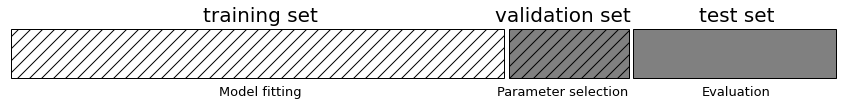

In [3]:
mglearn.plots.plot_threefold_split()

검증 세트를 이용하여 최적의 매개변수 선택 후 그 매개변수에서 훈련 세트와 검증 세트 데이터를 모두 이용해 모델 다시 만들기

-> 모델 만들 때 가능한 많은 데이터를 사용하기 위해서 (아래 이 과정을 구현한 코드)

In [4]:
from sklearn.svm import SVC
# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("훈련 세트의 크기: {}   검증 세트의 크기: {}   테스트 세트의 크기:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 검증 세트로 SVC를 평가합니다
        score = svm.score(X_valid, y_valid)
        # 점수가 더 높으면 매개변수와 함께 기록합니다
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든 후
# 테스트 세트를 사용해 평가
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("검증 세트에서 최고 점수: {:.2f}".format(best_score))
print("최적 파라미터: ", best_parameters)
print("최적 파라미터에서 테스트 세트 점수: {:.2f}".format(test_score))

훈련 세트의 크기: 84   검증 세트의 크기: 28   테스트 세트의 크기: 38

검증 세트에서 최고 점수: 0.96
최적 파라미터:  {'C': 10, 'gamma': 0.001}
최적 파라미터에서 테스트 세트 점수: 0.92


## 5.2.3 교차 검증을 사용한 그리드 서치
일반화 성능을 더 잘 평가하기 위해 교차 검증을 사용하여 각 매개변수 조합의 성능 평가하기

In [5]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        # 교차 검증을 적용
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # 교차 검증 정확도의 평균을 계산
        score = np.mean(scores)
        # 점수가 더 높으면 매개변수와 함께 기록
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만들기
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=10, gamma=0.1)

ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (36).

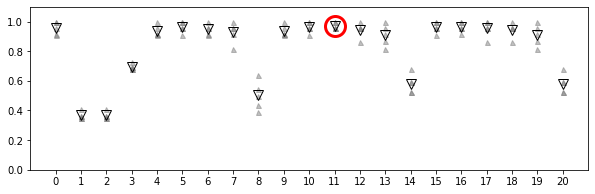

In [6]:
# 위의 코드에서 최적의 매개변수 선택하는 방법을 보여줌
mglearn.plots.plot_cross_val_selection()

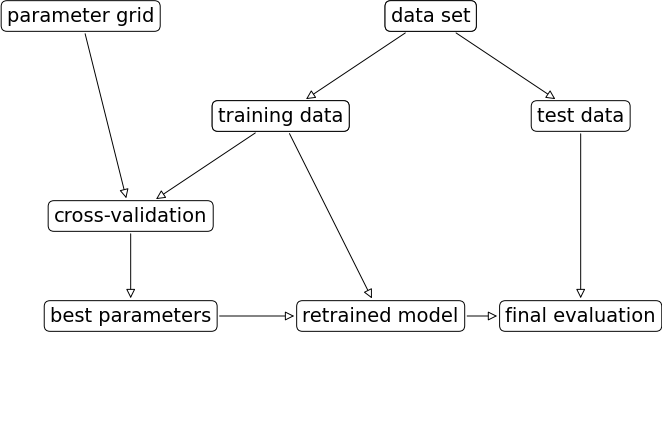

In [7]:
# 데이터를 나누고 그리드 서치를 적용하여 최종 매개변수를 평가하는 전체 과정
mglearn.plots.plot_grid_search_overview()

사이킷런에서 GridSearchCV를 제공하고 있으며 사용하려면 먼저 딕셔너리 형태로 검색 대상 매개변수를 지정해야 한다.

딕셔너리의 키는 조정하고자 하는 매개변수 이름, 값은 탐색할 매개변수 설정 값

In [8]:
# 딕서녀리 만들기
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("매개변수 그리드:\n", param_grid)

매개변수 그리드:
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [9]:
# GridSearchCV 객체 생성하기
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

In [10]:
# 매개변수가 과대적합 되는 것을 막기 위해 데이터를 훈련, 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)

In [11]:
# 교차 검증 수행
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [12]:
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))

테스트 세트 점수: 0.97


In [13]:
print("최적 매개변수:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 매개변수: {'C': 10, 'gamma': 0.1}
최고 교차 검증 점수: 0.97


In [14]:
print("최고 성능 모델:\n", grid_search.best_estimator_)

최고 성능 모델:
 SVC(C=10, gamma=0.1)


### 교차 검증 결과 분석
교차 검증의 결과를 시각화하면 매개변수가 모델의 일반화에 얼마나 영향을 주는지 이해하는데 도움이 된다

cv_results_ : 그리드 서치의 결과가 담겨있는 속성

In [15]:
import pandas as pd
pd.set_option('display.max_columns', None)
# DataFrame으로 변환
results = pd.DataFrame(grid_search.cv_results_)
# 처음 다섯 개 행을 출력
display(np.transpose(results.head()))

,0,1,2,3,4
mean_fit_time,0.00159268,0.00146937,0.00133514,0.000449514,0.000615835
std_fit_time,0.000476231,0.00111276,0.00076915,0.000556585,0.00081828
mean_score_time,0.000398684,0,0.000399828,0.000405645,9.00745e-05
std_score_time,0.000488286,0,0.000489687,0.00049691,0.000180149
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split2_test_score,0.363636,0.363636,0.363636,0.363636,0.363636


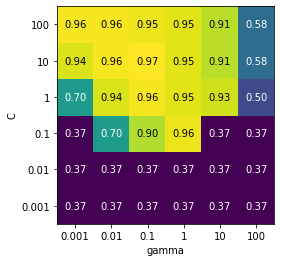

In [16]:
# 히트맵으로 시각화하기
scores = np.array(results.mean_test_score).reshape(6, 6)

# 교차 검증 평균 점수 히트맵 그래프
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

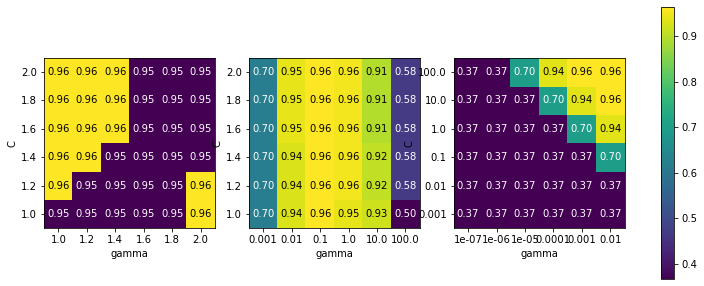

In [17]:
# 검색 범위가 적절하게 선택되지 않아 바람직하지 못한 결과를 내는 그래프 예
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                     'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # 교차 검증 평균 점수의 히트맵 그래프
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)
    
plt.colorbar(scores_image, ax=axes.tolist())

 ### 비대칭 매개변수 그리드 탐색
 커널이 linear인 경우는 C 매개변수만 사용하고 rbf인 경우는 gamma와 C를 모두 사용하므로 모든 매개변수 조합에 대해 수행하는 것이 좋지 않음 
 
 -> 조건부 매개변수 조합을 적용하기 위해 param_grid를 딕셔너리의 리스트로 만들어 주면 된다

In [18]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("그리드 목록:\n", param_grid)

그리드 목록:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [19]:
# 위의 매개변수를 그리드에 적용해보기
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("최적 파라미터:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 파라미터: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


In [20]:
# cv_results 속성 다시 살펴보기
results = pd.DataFrame(grid_search.cv_results_)
# 좀 더 나은 출력을 위해 결과를 전치시키기
display(results.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00115399,0.000708961,0.00244379,0,0.000209618,0.00161104,0,0,0.00502138,0.00259662,0.00153913,0.00160003,0,0,0.00159993,0.00320001,0,0.00182204,0,0.00161366,0,0.00163078,0.00159998,0.00353851,0.000655746,0.000398588,0.00039916,0.00294847,0.00194278,0.00243125,0.00162864,0.000415277,0.0016294,0.00321159,0.00340061,0.000415468,0.00181293,0.0020226,0.00160069,0.00162249,0.00160098,0.000210285
std_fit_time,0.00121136,0.000876824,0.00333242,0,0.000419235,0.00322208,0,0,0.00411979,0.00335626,0.00307827,0.00320005,0,0,0.00319986,0.00391919,0,0.00364408,0,0.00322733,0,0.00326157,0.00319996,0.00436669,0.00089981,0.000488169,0.000798321,0.00329121,0.00388556,0.00330004,0.00325727,0.000508612,0.0032588,0.00393343,0.00377339,0.000509355,0.00315119,0.00315891,0.00320139,0.00324497,0.00320196,0.00042057
mean_score_time,0.000599718,0.000206757,0.00162783,0,0,0.00165691,0,0,0,0.00191307,0.00181623,0,0.0032001,0,0,7.37667e-05,0,0.00160003,0,0.00159993,0.00162053,0,0.00161242,0.00261207,0.000325012,0,0,0.000350904,0.00162477,0.00133867,0.00161085,0.00162978,0,0,0,0.000321341,0.000123119,0,0.0015995,0.00183301,0,0
std_score_time,0.00048967,0.000413513,0.00325565,0,0,0.00331383,0,0,0,0.00309908,0.00315452,0,0.00391931,0,0,0.000147533,0,0.00320005,0,0.00319986,0.00324106,0,0.00322485,0.00323391,0.000650024,0,0,0.000434443,0.00324955,0.00219213,0.0032217,0.00325956,0,0,0,0.000642681,0.000246239,0,0.00319901,0.00311765,0,0
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,

### 그리디 서치에 다양한 교차 검증 적용
GridSearchCV는 분류에는 계층형 k-겹 교차 검증, 회귀에는 k-겹 교차 검증 사용

### 중첩 교차 검증
**중첨 교차 검증** : 원본 데이터를 훈련, 테스트 세트로 한 번만 나누는 방식 대신 더 나아가 교차 검증 분할 방식 사용 가능, 특정 데이터셋에서 주어진 모델이 얼마나 잘 일반화되는지 평가하는데 유용한 방법

바깥쪽 루프 : 데이터를 훈련, 테스트 세트로 나누고 그리드 서치 실행

안쪽 루프 : 바깥쪽에서 분할된 테스트 세트의 점수를 최적의 매개변수 설정을 사용해 각각 측정

In [21]:
# 중첩 교차 검증 (사이킷런 활용하기)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("교차 검증 점수: ", scores)
print("교차 검증 평균 점수: ", scores.mean())
print(param_grid)

교차 검증 점수:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
교차 검증 평균 점수:  0.9800000000000001
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [22]:
# for문을 이용해서 구현해보기
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # outer_cv의 분할을 순회하는 for 루프
    # (split 메소드는 훈련과 테스트 세트에 해당하는 인덱스를 리턴)
    for training_samples, test_samples in outer_cv.split(X, y):
        # 최적의 매개변수를 찾습니다
        best_parms = {}
        best_score = -np.inf
        # 매개변수 그리드를 순회
        for parameters in parameter_grid:
            # 안쪽 교차 검증의 점수를 기록
            cv_scores = []
            # inner_cv의 분할을 순회하는 for 루프
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # 훈련 데이터와 주어진 매개변수로 분류기를 만듭니다
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 검증 세트로 평가합니다
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 안쪽 교차 검증의 평균 점수를 계산
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 점수가 더 높은면 매개변수와 함께 기록
                best_score = mean_score
                best_params = parameters
        # 바깥쪽 훈련 데이터 전체를 사용해 분류기를 만듭니다
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # 테스트 세트를 사용해 평가
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [23]:
# 위 함수를 iris 데이터셋에 적용하기
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("교차 검증 점수:", scores)

교차 검증 점수: [0.96666667 1.         0.96666667 0.96666667 1.        ]


### 교차 검증과 그리드 서치 병렬화
그리드 서치는 데이터 용량이 크고 매개변수 수가 많을 때는 상당한 부하를 일으키지만 쉽게 병렬화 할 수 있다.

## 5.3 평가 지표와 측정
지금까지 분류 성능 평가에는 정확도, 회귀 성능 평가에는 R^을 사용했지만 지도학습 모델의 성능을 재는 방법은 이 외에도 많다.

### 5.3.1 최종 목표를 기억하라
머신러닝 평가 지표를 선택하기 전 비즈니스 지표라고 부르는 애플리케이션의 고차원적인 목표를 생각해야 한다.

### 5.3.2 이진 분류 평가 지표
이진 분류에는 양성 클래스와 음성 클래스가 있으며 양성 클래스가 우리의 관심 클래스

#### 에러의 종류
암을 조기 발견하는 애플리케이션을 가정
**거짓 양성** : 건강한 사람을 양성으로 분류한 경우
**거짓 음성** : 암에 걸린 사람을 음성으로 분류한 경우

위의 경우 거짓 음성을 최대한 피해야하지만 거짓 양성은 비교적 중요도가 낮음

#### 불균형 데이터셋
불균형 데이터셋 : 한 클래스가 다른 것보다 훨씬 많은 데이터셋

현실에서는 불균형 데이터가 훨씬 많다

ex) 100개의 광고에서 클릭이 아닌 데이터 99와 클릭한 데이터 1개

In [24]:
# digits 데이터셋을 사용해 숫자 9를 다른 숫자와 구분하여 9:1 불균형한 데이터셋 만들기
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

In [25]:
# 정확도 계산하기
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("예측된 레이블의 고유값:", np.unique(pred_most_frequent))
print("테스트 점수: {:.2f}".format(dummy_majority.score(X_test, y_test)))

예측된 레이블의 고유값: [False]
테스트 점수: 0.90


위의 결과 아무것도 학습시키지 않고 90% 정확도를 얻음

In [26]:
# 실제 분류기 사용하기
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("테스트 점수: {:.2f}".format(tree.score(X_test, y_test)))

테스트 점수: 0.92


In [27]:
# 비교를 위해 LogisticRegression과 기본 DummyClassifier 분류기 두 개를 더 살펴보기
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy 점수: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1, max_iter=1000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg 점수: {:.2f}".format(logreg.score(X_test, y_test)))

dummy 점수: 0.83
logreg 점수: 0.98


더미 분류기 조차 80%를 맞춤 -> 불균형 데이터셋에서 예측을 정량화하는 데 정확도는 적절한 측정 방법이 아님

pred_most_frequent와 pred_dummy처럼 빈도나 무작위 기반 예측보다 얼마나 나은지 알려주는 평가 지표가 필요함

### 오차 행렬
오차행렬 : 이진 분류 평가 겨로가를 나타낼 때 널리 사용하는 방법 중 하나

In [28]:
# LogsticRegression 예측 결과를 confusion_matrix 함수를 사용해서  확인해보기
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("오차 행렬:\n", confusion)

오차 행렬:
 [[402   1]
 [  6  41]]


위의 행렬에서 행은 정답 클래스, 열은 예측 클래스에 해당

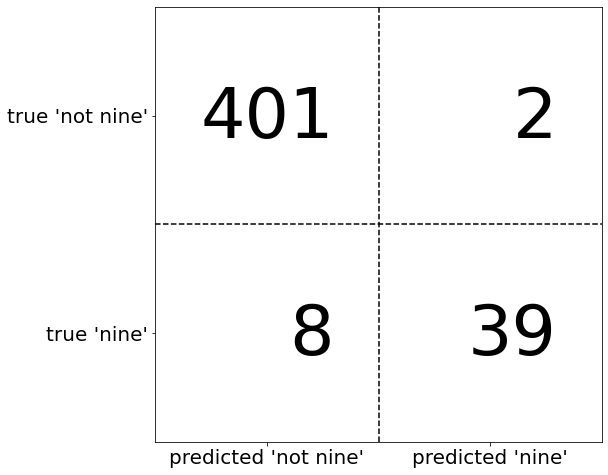

In [29]:
# '9와 9 아님' 분류 문제의 오차 행렬
mglearn.plots.plot_confusion_matrix_illustration()

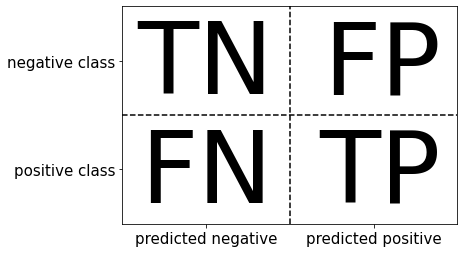

In [30]:
#진짜양성, 진짜 음성, 거짓 양성, 거짓 음성 분류
mglearn.plots.plot_binary_confusion_matrix()

In [31]:
# 오차 행렬을 이용하여 위에서 만든 모델들 비교하기( 더미모델 2개, 결정 트리, 로지스틱 회귀)
print("빈도 기반 더미 모델:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\n무작위 더미 모델:")
print(confusion_matrix(y_test, pred_dummy))
print("\n결정 트리:")
print(confusion_matrix(y_test, pred_tree))
print("\n로지스틱 회귀")
print(confusion_matrix(y_test, pred_logreg))

빈도 기반 더미 모델:
[[403   0]
 [ 47   0]]

무작위 더미 모델:
[[361  42]
 [ 44   3]]

결정 트리:
[[390  13]
 [ 24  23]]

로지스틱 회귀
[[402   1]
 [  6  41]]


전체 오차 행렬을 조사하기는 번거롭다 (매우 수동적이다) -> 행렬 정보 요약할 수 있는 여러 방법 아래에서 알아보기

### 정확도와의 관계
정확도로 표현하기 -> 정확히 예측한 수(진짜 양성과 진짜 음성)을 전체 샘흘 수 (오차 행렬의 모든 항목을 더한값)으로 나눈 것

### 정밀도, 재현율 , f-점수
오차 행렬 결과를 요약하는 여러 방법 중 가장 일반적임

**정밀도** : 양성으로 예측된 것 중 얼마나 많은 샘플이 진짜 양성인지 측정 

**재현율** : 전체 양성 샘플 중에서 얼마나 많은 샘플이 양성 클래스로 분류되는지 측정

**f-점수** : 정밀도와 재현율의 조화 평균


In [32]:
#f1 점수를 위에서 계산한 '9와 9 아님' 데이터 셋의 예측에 적용해보기
from sklearn.metrics import f1_score
print("빈도 기반 더미 모델의 f1 score: {:.2f}".format(
    f1_score(y_test, pred_most_frequent)))
print("무작위 더미 모델의 f1 score: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("트리 모델의 f1 score: {:.2f}".format(f1_score(y_test, pred_tree)))
print("로지스틱 회귀 모델의 f1 score: {:.2f}".format(
    f1_score(y_test, pred_logreg)))

빈도 기반 더미 모델의 f1 score: 0.00
무작위 더미 모델의 f1 score: 0.07
트리 모델의 f1 score: 0.55
로지스틱 회귀 모델의 f1 score: 0.92


In [33]:
# classfication_report : 정밀도, 재현유, f1-점수 모두를 한 번에 계산해서 깔끔하게 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, # 빈도 기반 더미 모델
                            target_names=["9 아님", "9"]))

              precision    recall  f1-score   support

        9 아님       0.90      1.00      0.94       403
           9       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(classification_report(y_test, pred_dummy, # 무작위 더미 분류기
                            target_names=["9 아님", "9"]))

              precision    recall  f1-score   support

        9 아님       0.89      0.90      0.89       403
           9       0.07      0.06      0.07        47

    accuracy                           0.81       450
   macro avg       0.48      0.48      0.48       450
weighted avg       0.81      0.81      0.81       450



In [35]:
print(classification_report(y_test, pred_logreg, # 로지스틱 회귀
                            target_names=["9 아님", "9"]))

              precision    recall  f1-score   support

        9 아님       0.99      1.00      0.99       403
           9       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



### 불확실성 고려
오차 행렬과 분류 리포트가 예측 결과를 자세히 분석할 수 있도록 도와주지만 예측값은 모델에 담긴 많은 정보가 손실된 상태

In [36]:
# 음성 클래스 400, 양성 클래스 50개로 이루어진 데이터에 SVM을 학습 후 결정 함수 값을 히트맴으로 나타내기
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train) 

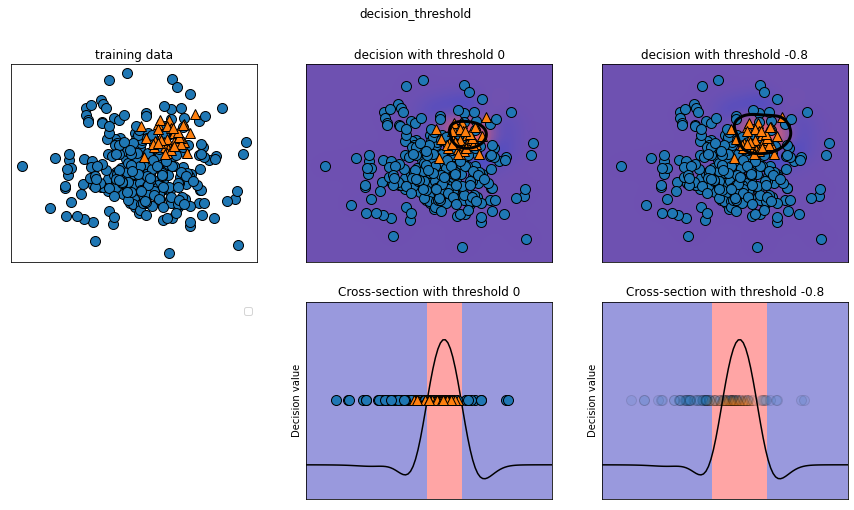

In [37]:
mglearn.plots.plot_decision_threshold()

In [38]:
# classfication_report 함수를 이용하여 두 클래스의 정밀도와 재현율 평가
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



In [39]:
# 임계값을 낮추어 클래스 1의 재현율 높이도록 예측 조정하기
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [40]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



### 정밀도-재현율 곡선과 ROC 곡선

임계값을 바꾸는 것 -> 분류기의 정밀도와 재현율의 상충 관계를 조정하는 일

운영 포인트 : 분류기의 필요조건을 지정하는 것

정밀도-재현율 곡선 : 운영 포인트가 명확하지 않은 경우 모든 임계값을 조사해보거나 한번에 정밀도나 재현율의 모든 장단점ㅁ 살펴보기 위해 사용 (사이킷런에서 제공)

In [42]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve( 
    # precision_recall_curve 함수는 가능한 모든 임계값에 대해 정밀도와 재현율 값을 정렬된 리스트로 반환
    y_test, svc.decision_function(X_test))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50984 missing from c

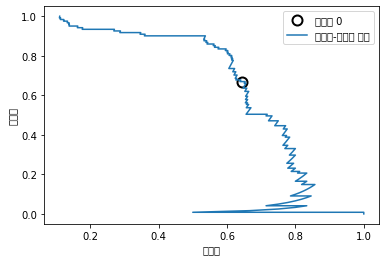

In [44]:
# 곡선 그래프 그리기
# 부드러운 곡선을 위해 데이터 포인트 수를 늘립니다
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)
`
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))
# 0에 가까운 임계값을 찾습니다
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="임계값 0", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="정밀도-재현율 곡선")
plt.xlabel("정밀도")
plt.ylabel("재현율")
plt.legend(loc="best")

분류기가 다르면 운영 포인트가 달라진다

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50984 missing from c

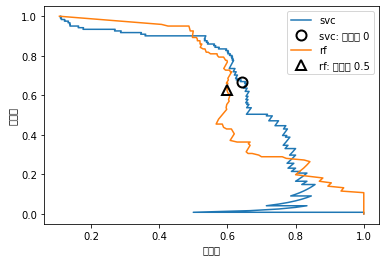

In [45]:
# 랜덤 포레스트와 SVM 비교하기 (SVM과 랜덤 포레스트의 정밀도-재현율 곡선 비교)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier는 decision_function 대신 predict_proba를 제공합니다.
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="svc: 임계값 0", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="rf: 임계값 0.5", fillstyle="none", mew=2)
plt.xlabel("정밀도")
plt.ylabel("재현율")
plt.legend(loc="best")

In [46]:
# f1 점수 -> 정밀도-재현율 곡선의 한 지점인 기본 임계값에 대한 점수
print("랜덤 포레스트의 f1_score: {:.3f}".format(
    f1_score(y_test, rf.predict(X_test))))
print("svc의 f1_score: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

랜덤 포레스트의 f1_score: 0.610
svc의 f1_score: 0.656


정밀도-재현율 곡선을 비교하면 수작업임 -> 자동으로 비교하기 위해 요약 방법의 하나로 정밀도-재현율 곡선의 아랫부분 면적을 계산할 수 있으며 **평균 정밀도**라고 함 (average_precision_score 함수)

In [47]:
# averate_precision_score 함수를 이용
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("랜덤 포레스트의 평균 정밀도: {:.3f}".format(ap_rf))
print("svc의 평균 정밀도: {:.3f}".format(ap_svc))

랜덤 포레스트의 평균 정밀도: 0.660
svc의 평균 정밀도: 0.666


### ROC와 AUC
**ROC 곡선** : 여러 임계값에서 분류기의 특성을 분석하는데 널리 사용하는 도구로 정밀도-재현율 곡선과 비슷하지만 정밀도와 재현율 대신 **진짜 양성비율에 대한 거짓 양성비율**을 나타낸다

roc_curve 함수를 이용하여 만들 수 있다

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44257 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51076 missing from c

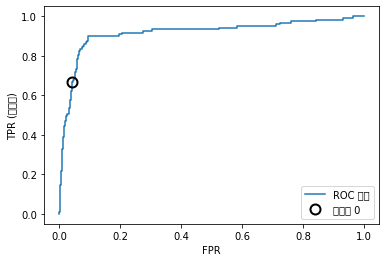

In [49]:
# SVM의 ROC 곡선
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC 곡선")
plt.xlabel("FPR")
plt.ylabel("TPR (재현율)")
# 0 근처의 임계값을 찾습니다
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="임계값 0", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44257 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49440 missing from c

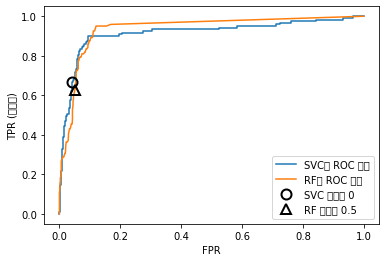

In [50]:
# SVM과 램덤 포레스트의 ROC 곡선 비교
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="SVC의 ROC 곡선")
plt.plot(fpr_rf, tpr_rf, label="RF의 ROC 곡선")

plt.xlabel("FPR")
plt.ylabel("TPR (재현율)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="SVC 임계값 0", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="RF 임계값 0.5", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

In [51]:
# AUC (곡선 아래의 면적값) 구하기 -> roc_auc_score 함수 이용
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("랜덤 포레스트의 AUC: {:.3f}".format(rf_auc))
print("SVC의 AUC: {:.3f}".format(svc_auc))

랜덤 포레스트의 AUC: 0.937
SVC의 AUC: 0.916


gamma = 1.00  정확도 = 0.90  AUC = 0.50
gamma = 0.10  정확도 = 0.90  AUC = 0.96
gamma = 0.01  정확도 = 0.90  AUC = 1.00


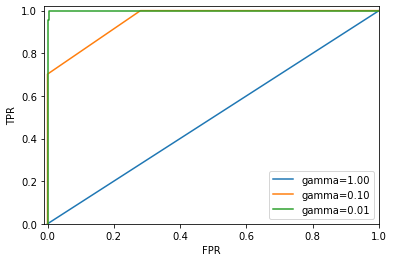

In [53]:
# 위에서 한 digits 데이터셋에서 9외 다른 숫자 구분 문제
# 커널 폭 gamma를 다르게한 SVM을 데이터셋에 적용해보기
# 각기 다른 gamma를 가진 SVM의 ROC 곡선 비교
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.2f}  정확도 = {:.2f}  AUC = {:.2f}".format(
        gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.2f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

## 5.3.3 다중 분류의 평가 지표

In [54]:
# digits 데이터셋의 10개 손글씨 숫자 분류에 적용해보기
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train)
pred = lr.predict(X_test)
print("정확도: {:.3f}".format(accuracy_score(y_test, pred)))
print("오차 행렬:\n", confusion_matrix(y_test, pred))

정확도: 0.953
오차 행렬:
 [[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


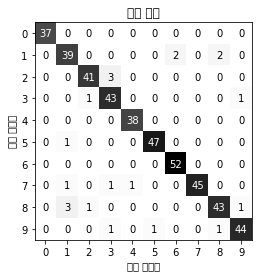

In [56]:
# 10개 숫자 분류 문제의 오차 행렬
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='예측 레이블',
    ylabel='진짜 레이블', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("오차 행렬")
plt.gca().invert_yaxis()

In [57]:
# classfication_report 함수를 사용하여 정밀도, 재현울, f1-점수 계산하기
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



다중 클래스용 f1-점수는 한 클래스를 양성 클래스로 두고 나머지 클래스들을 음성 클래스로 간주하여 클래스마다 f1-점수를 계산 후 평균을 낸다

In [58]:
print("micro 평균 f1 점수: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("macro 평균 f1 점수: {:.3f}".format(f1_score(y_test, pred, average="macro")))

micro 평균 f1 점수: 0.953
macro 평균 f1 점수: 0.954


### 5.3.4 회귀의 평가 지표
일반적으로 R^2이 회귀 모델을 평가하는 데 더 나은 지표

### 5.3.5 모델에서 평가 지표 사용하기

In [59]:
# 9와 9 아님을 분류하는 SVM 모델을 평균 정밀도 점수로 평가해보기
# 정확도에서 평균 정밀도로 바꾸려면 scoring 매개변수에 averate_precision이라고 지정하면 된다
# 분류의 기본 평가 지표는 정확도 입니다
print("기본 평가 지표:",
      cross_val_score(SVC(), digits.data, digits.target == 9, cv=5))
# scoring="accuracy"의 결과와 같습니다.
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9,
                                     scoring="accuracy", cv=5)
print("정확도 지표:", explicit_accuracy)
ap =  cross_val_score(SVC(), digits.data, digits.target == 9,
                           scoring="average_precision", cv=5)
print("평균 정밀도 지표:", ap)

기본 평가 지표: [0.975      0.99166667 1.         0.99442897 0.98050139]
정확도 지표: [0.975      0.99166667 1.         0.99442897 0.98050139]
평균 정밀도 지표: [0.97562403 0.9886322  1.         0.99853801 0.95015534]


In [61]:
# cross_validate 함수를 사용하여 한 번에 여러 측정 지표 계산하기
from sklearn.model_selection import cross_validate
res = cross_validate(SVC(), digits.data, digits.target == 9,
                     scoring=["accuracy", "average_precision", "recall_macro"],
                     return_train_score=True, cv=5)
display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_average_precision,train_average_precision,test_recall_macro,train_recall_macro
0,0.052969,0.025932,0.975000,0.994433,0.975624,0.994997,0.887346,0.972222
1,0.057421,0.024004,0.991667,0.995825,0.988632,0.996010,0.958333,0.982252
2,0.081239,0.034915,1.000000,0.995132,1.000000,0.995317,1.000000,0.978780
3,0.057202,0.024000,0.994429,0.995828,0.998538,0.995257,0.972222,0.982252
4,0.065946,0.025009,0.980501,0.996523,0.950155,0.999257,0.902778,0.985725


In [62]:
# GridSearchCV에서 최적의 매개변수를 선택하기 위한 평가 지표 바꿀 수 있음
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# 일부러 적절하지 않은 그리드를 만듭니다
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
# 기본 정확도 측정 지표를 사용합니다
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("정확도 지표를 사용한 그리드 서치")
print("최적의 파라미터:", grid.best_params_)
print("최상의 교차 검증 점수 (정확도)): {:.3f}".format(grid.best_score_))
print("테스트 세트 평균 정밀도: {:.3f}".format(
      average_precision_score(y_test, grid.decision_function(X_test))))
print("테스트 세트 정확도: {:.3f}".format(
      # grid.score 점수와 동일합니다
      accuracy_score(y_test, grid.predict(X_test))))

정확도 지표를 사용한 그리드 서치
최적의 파라미터: {'gamma': 0.0001}
최상의 교차 검증 점수 (정확도)): 0.976
테스트 세트 평균 정밀도: 0.966
테스트 세트 정확도: 0.973


In [63]:
# 평균 정밀도 지표 사용
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="average_precision")
grid.fit(X_train, y_train)
print("평균 정밀도 지표를 사용한 그리드 서치")
print("최적의 파라미터:", grid.best_params_)
print("최상의 교차 검증 점수 (평균 정밀도): {:.3f}".format(grid.best_score_))
print("테스트 세트 평균 정밀도: {:.3f}".format(
      # grid.score 점수와 동일합니다
      average_precision_score(y_test, grid.decision_function(X_test))))
print("테스트 세트 정확도: {:.3f}".format(
      accuracy_score(y_test, grid.predict(X_test))))

평균 정밀도 지표를 사용한 그리드 서치
최적의 파라미터: {'gamma': 0.01}
최상의 교차 검증 점수 (평균 정밀도): 0.988
테스트 세트 평균 정밀도: 0.996
테스트 세트 정확도: 0.896
